# L09 Softmax Classifer[Softmax+NLLLoss]

In [1]:
import torch
import numpy as np

BATCH_SIZE = 64
NET_LAYER = [784, 512, 256, 128, 64, 10]
NET_LAYER_SIZE = len(NET_LAYER)-1

In [2]:
# data
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, )) ])
train_dataset = datasets.MNIST(root='dataset/mnist', train=True, transform=transform, download=True) 
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = datasets.MNIST(root='dataset/mnist', train=False, transform=transform, download=True) 
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [30]:
# model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear = torch.nn.ModuleList()
        for layer in range(NET_LAYER_SIZE):
            self.linear.append(torch.nn.Linear(NET_LAYER[layer], NET_LAYER[layer+1]))
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.LogSoftmax(dim=1) ## = torch.nn.Softmax(dim=1) + log; since NLLLoss need Log first, use this
    
    def forward(self, x):
        x = x.view(-1, 784) # (N,1,28,28) to (N,784)
        for layer in range(NET_LAYER_SIZE-1): # last layer donot need RELU activate
            x = self.relu(self.linear[layer](x))
        return self.softmax(self.linear[NET_LAYER_SIZE-1](x))
    
net = Net()

In [31]:
# criterion
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

In [32]:
# train
def train(epoch):
    running_loss = 0
    for batch_i, (x, y) in enumerate(train_loader):
        y_hat = net(x)
        loss = criterion(y_hat, y.long()) # torch.Tensor() is float, torch.LongTensor() is num; in this case, .long() removed is ok
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
    if(running_loss <= 1e-5 or epoch >= 2):
        return True, epoch, running_loss / BATCH_SIZE
    else:
        epoch += 1
        return False, epoch, running_loss / BATCH_SIZE

In [33]:
# test
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for (x, y) in test_loader:
            y_hat = net(x)
            value, pred_index = torch.max(y_hat.data, dim=1)
            total += y.size(0)
            correct += (pred_index == y).sum().item()
    return correct / total

In [34]:
# epoch
epoch = 0
loss = []
accurate_rate = []

while True:
    train_over, epoch, epoch_loss = train(epoch) 
    loss.append(epoch_loss)
    acc = test()
    accurate_rate.append(acc)
    
    if(train_over):
        break

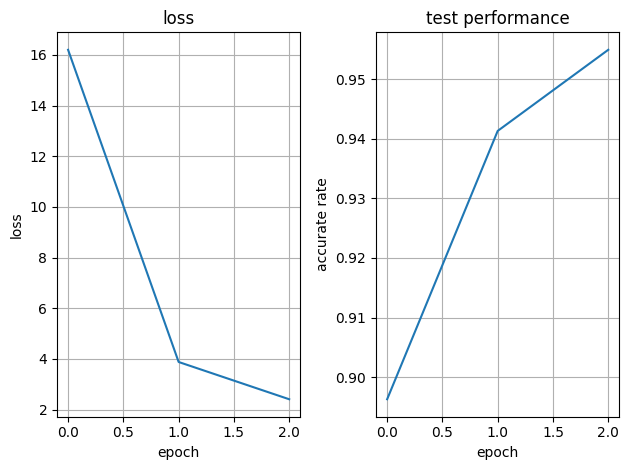

In [35]:
# plot
import matplotlib.pyplot as plt

plt.subplot(121)
plt.title("loss")
plt.plot(loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)

plt.subplot(122)
plt.title("test performance")
plt.plot(accurate_rate)
plt.xlabel("epoch")
plt.ylabel("accurate rate")
plt.grid(True)

plt.tight_layout()
plt.savefig("image/L09[S+N]_performance.png")
plt.show()